In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
import h5py as h5
import matplotlib.pyplot as plt

### Reading data

The sets in the dataset are divided into five categories.


SET A:	Z directory with	Z000.txt - Z100.txt<br>
SET B: 	O directory with	O000.txt - O100.txt<br>
SET C:	N directory with	N000.txt - N100.txt<br>
SET D:	F directory	with	F000.txt - F100.txt<br>
SET E:	S directory with	S000.txt - S100.txt<br>

In [4]:
mapping_set_to_dir = {
    'A': (0,'Z'),
    'B': (1,'O'),
    'C': (2,'N'),
    'D': (3,'F'),
    'E': (4,'S')
}

export_to = 'random-iter-3/'

file_lists = []
for s,d in mapping_set_to_dir.items():
    file_lists.insert(d[0], [f for f in listdir(d[1]) if isfile(join(d[1], f))])

In [5]:
file_lists[4]

['S008.txt',
 'S020.txt',
 'S034.txt',
 'S035.txt',
 'S021.txt',
 'S009.txt',
 'S037.txt',
 'S023.txt',
 'S022.txt',
 'S036.txt',
 'S032.txt',
 'S026.txt',
 'S027.txt',
 'S033.txt',
 'S025.txt',
 'S031.txt',
 'S019.txt',
 'S018.txt',
 'S030.txt',
 'S024.txt',
 'S043.txt',
 'S057.txt',
 'S080.txt',
 'S094.txt',
 'S095.txt',
 'S081.txt',
 'S056.txt',
 'S042.txt',
 'S068.txt',
 'S054.txt',
 'S040.txt',
 'S097.txt',
 'S083.txt',
 'S082.txt',
 'S096.txt',
 'S041.txt',
 'S055.txt',
 'S069.txt',
 'S051.txt',
 'S045.txt',
 'S079.txt',
 'S092.txt',
 'S086.txt',
 'S087.txt',
 'S093.txt',
 'S078.txt',
 'S044.txt',
 'S050.txt',
 'S046.txt',
 'S052.txt',
 'S085.txt',
 'S091.txt',
 'S090.txt',
 'S084.txt',
 'S053.txt',
 'S047.txt',
 'S062.txt',
 'S076.txt',
 'S089.txt',
 'S088.txt',
 'S077.txt',
 'S063.txt',
 'S049.txt',
 'S075.txt',
 'S061.txt',
 'S100.txt',
 'S060.txt',
 'S074.txt',
 'S048.txt',
 'S070.txt',
 'S064.txt',
 'S058.txt',
 'S059.txt',
 'S065.txt',
 'S071.txt',
 'S067.txt',
 'S073.txt',

In [6]:
raw_dataset = { }

for s,d in mapping_set_to_dir.items():
    
    for f in file_lists[d[0]]:
        curr_example = np.loadtxt(join(d[1], f))
        

        if (s in raw_dataset):
            raw_dataset[s] = np.append(raw_dataset[s], [curr_example], axis=0)
        else:
            raw_dataset[s] = np.array([curr_example])

In [7]:
raw_dataset['E'].shape

(100, 4097)

## Visualizing data

Each training example in raw_dataset contains an EEG signal of 4097 data points.<br>
The values represent the values of voltage levels observed by the electrodes.<br>

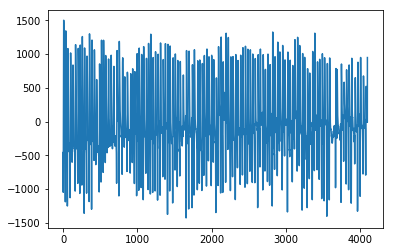

In [8]:
s = 'E'
index = 40
plt.plot(raw_dataset[s][index])

## Data augmentation

Since neural networks are hungry for data to perform adequately, and the available data has only 500 examples of data (100 per set). A good solution to this problem would be to split the data into smaller signals. In this manner, we'll have lots of examples, albeit small.

The below procedure uses sliding window with specified `window_size` and `stride` and returns a new dataset.

In [9]:
def create_augmented_dataset(raw_dataset, window_size = 512, stride = 64, verbose=False):
    augmented_dataset = { }

    for s,Xset_raw in raw_dataset.items():
        
        if (verbose):
            print('Processing set ' + s)

        total_points = Xset_raw.shape[1]

        # no. of examples generated from single training example using sliding window
        # = floor((total_points - window_size) / stride) + 1
        iterations = ((total_points - window_size) // stride) + 1

        for x_raw in Xset_raw:

            for i in range(iterations):
                window_slice_from = i*stride
                window_slice_to = i*stride + window_size

                if (s in augmented_dataset):
                    augmented_dataset[s] = np.append(augmented_dataset[s], [x_raw[window_slice_from:window_slice_to]], axis=0)
                else:
                    augmented_dataset[s] = np.array([x_raw[window_slice_from:window_slice_to]])

    
    if (verbose):
        print('Done.')
    return augmented_dataset


# Splitting of the data

Our methodology to split the data is ...

In [10]:
raw_dataset_train = { }
raw_dataset_dev = { }
raw_dataset_test = { }

for s,Xset_raw in raw_dataset.items():
    
    # randomly shuffle the data, just to make sure
    # that all train/dev/test sets come from same
    # distribution, (possibly not from a same person)
    np.random.shuffle(raw_dataset[s])
    
    ninety_percent = np.floor(0.9 * raw_dataset[s].shape[0]).astype(int)
    five_percent = np.floor(0.05 * raw_dataset[s].shape[0]).astype(int)
    
    # train set 0 - 89 (90%)
    raw_dataset_train[s] = raw_dataset[s][0:ninety_percent,:]
    
    # dev set 90 - 94 (5%)
    raw_dataset_dev[s] = raw_dataset[s][ninety_percent:ninety_percent+five_percent,:]
    
    # test set 95 - 99 (5%)
    raw_dataset_test[s] = raw_dataset[s][ninety_percent+five_percent:,:]

In [11]:
print(raw_dataset_train['D'].shape)
print(raw_dataset_dev['A'].shape)
print(raw_dataset_test['C'].shape)

(90, 4097)
(5, 4097)
(5, 4097)


#### Scheme - 1

Let's try splitting the data with the window size of 512 and stride of 64. As done in the Scheme-1 of the Paper by Ihsan Ullah et. al. This method creates 28,500 examples from 500 examples. (5700 per set).

In [12]:
print("Augmenting training data")
aug_dataset512_train = create_augmented_dataset(raw_dataset_train, window_size=512, stride=64, verbose=True)

print("Augmenting dev data")
aug_dataset512_dev = create_augmented_dataset(raw_dataset_dev, window_size=512, stride=256, verbose=True)

print("Augmenting test data")
aug_dataset512_test = create_augmented_dataset(raw_dataset_test, window_size=512, stride=256, verbose=True)

Augmenting training data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting dev data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting test data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.


#### Scheme - 2

Also, try the window size of 1024 with the stride of 128. Creates 12,500 examples (2500 per set).

In [13]:
print('Augmenting training data')
aug_dataset1024_train = create_augmented_dataset(raw_dataset_train, window_size=1024, stride=128, verbose=True)

print ('Augmenting dev data')
aug_dataset1024_dev = create_augmented_dataset(raw_dataset_dev, window_size=1024, stride=512, verbose=True)

print('Augmenting test data')
aug_dataset1024_test = create_augmented_dataset(raw_dataset_test, window_size=1024, stride=512, verbose=True)

Augmenting training data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting dev data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting test data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.


In [14]:
print(aug_dataset512_train['E'].shape)
print(aug_dataset512_dev['C'].shape)
print(aug_dataset512_test['D'].shape)

(5130, 512)
(75, 512)
(75, 512)


In [15]:
print(aug_dataset1024_train['E'].shape)
print(aug_dataset1024_dev['C'].shape)
print(aug_dataset1024_test['D'].shape)

(2250, 1024)
(35, 1024)
(35, 1024)


## Saving the data

Calling the `create_augmented_dataset` for the above parameters takes few minutes each time. To speed up learning these augmented datasets are saved to the disk so that they can be loaded next time feasibly. We use a popular library called `h5py` for this purpose.

In [17]:
with h5.File(export_to + 'aug_dataset512.h5', 'w') as aug_file512:
    
    train512 = aug_file512.create_group('train')
    dev512 = aug_file512.create_group('dev')
    test512 = aug_file512.create_group('test')

    for s in aug_dataset512_train.keys():
        
        train512.create_dataset(s, data=aug_dataset512_train[s])
        dev512.create_dataset(s, data=aug_dataset512_dev[s])
        test512.create_dataset(s, data=aug_dataset512_test[s])
        

In [18]:
with h5.File(export_to + 'aug_dataset1024.h5', 'w') as aug_file1024:
    
    train1024 = aug_file1024.create_group('train')
    dev1024 = aug_file1024.create_group('dev')
    test1024 = aug_file1024.create_group('test')

    for s in aug_dataset1024_train.keys():
        
        train1024.create_dataset(s, data=aug_dataset1024_train[s])
        dev1024.create_dataset(s, data=aug_dataset1024_dev[s])
        test1024.create_dataset(s, data=aug_dataset1024_test[s])

In [19]:
aug_file512 = h5.File(export_to + 'aug_dataset512.h5', 'r')
print(aug_file512['train']['A'].shape)
print(aug_file512['dev']['C'].shape)
print(aug_file512['test']['D'].shape)

(5130, 512)
(75, 512)
(75, 512)


In [20]:
aug_file1024 = h5.File(export_to + 'aug_dataset1024.h5', 'r')
print(aug_file1024['train']['A'].shape)
print(aug_file1024['dev']['C'].shape)
print(aug_file1024['test']['D'].shape)

(2250, 1024)
(35, 1024)
(35, 1024)


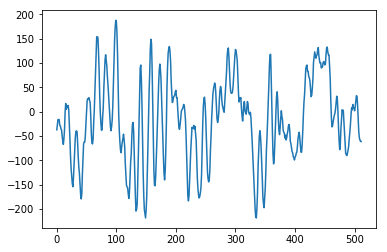

In [21]:
s = 'B'
index = 400
plt.plot(aug_file512['train'][s][index])

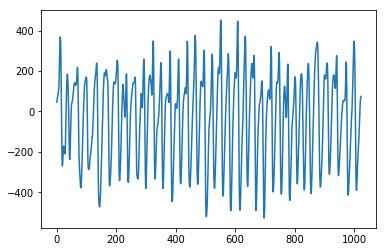

In [22]:
s = 'E'
index = 175
plt.plot(aug_file1024['train'][s][index])

In [23]:
aug_file512.close()

In [24]:
aug_file1024.close()

## One-hot labels

Let's convert the dataset which is in dictionary format, to a single giant training set which contains all classes and a label set represented in one-hot format.

In [25]:
import tensorflow as tf

In [26]:
# For 3 class classification
class_map = { 'A': 0, 'B': 0, 'C': 1, 'D': 1, 'E': 2 }

def read_dataset_and_one_hot_labels(filepath, setname, verbose=False):
    data = { }

    # Read dataset that is already stored in the file
    with h5.File(filepath, 'r') as aug_file:

        # classes are AB, CD, and E
        no_of_classes = 3

        for s in aug_file[setname].keys():
            
            if (verbose):
                print("Processing class: " + s)
            
            class_length = len(aug_file[setname][s])
            
            # go through each example in the class
            for i in range(class_length):
                
                if (verbose and i % (class_length / 5) == 0):
                    print((str)((int)(i / class_length * 100)) + '%')
                
                # create a big (combination of all classes) dataset
                # and also set their labels in a separate array
                if (('X_' + setname) in data):
                    data['X_' + setname] = np.append(data['X_' + setname], [aug_file[setname][s][i]], axis=0)
                    data['Y_' + setname + '_classname'] = np.append(data['Y_' + setname + '_classname'], [class_map[s]], axis=0)
                else:
                    data['X_' + setname] = np.array([aug_file[setname][s][i]])
                    data['Y_' + setname + '_classname'] = np.array([class_map[s]])


        
        if (verbose):
            print("Converting to one_hot")
            
        # use tensorflow one_hot function to convert labels into one_hot values
        tf.reset_default_graph()
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
            data['Y_' + setname] = sess.run(tf.one_hot(data['Y_' + setname + '_classname'], depth=no_of_classes, axis=-1))
        
        if (verbose):
            print("Done.")

    return data

In [27]:
print("Converting training set to one hot")
data512_train = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'train', verbose=True)
print("Converting dev set to one hot")
data512_dev = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'dev', verbose=True)
print("Converting test set to one hot")
data512_test = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'test', verbose=True)

Converting training set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting dev set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting test set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.


In [28]:
with h5.File(export_to + 'datafile512.h5', 'w') as datafile512:

    datafile512.create_dataset('X_train', data=data512_train['X_train'])
    datafile512.create_dataset('Y_train_classname', data=data512_train['Y_train_classname'])
    datafile512.create_dataset('Y_train', data=data512_train['Y_train'])
    
    datafile512.create_dataset('X_dev', data=data512_dev['X_dev'])
    datafile512.create_dataset('Y_dev_classname', data=data512_dev['Y_dev_classname'])
    datafile512.create_dataset('Y_dev', data=data512_dev['Y_dev'])
    
    datafile512.create_dataset('X_test', data=data512_test['X_test'])
    datafile512.create_dataset('Y_test_classname', data=data512_test['Y_test_classname'])
    datafile512.create_dataset('Y_test', data=data512_test['Y_test'])

(25650, 512)
(25650,)
(25650, 3)
(375, 512)
(375,)
(375, 3)
(375, 512)
(375,)
(375, 3)
Label: [1. 0. 0.]


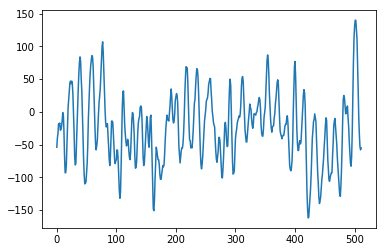

In [29]:
with h5.File(export_to + 'datafile512.h5', 'r') as datafile512:
    
    print(datafile512['X_train'].shape)
    print(datafile512['Y_train_classname'].shape)
    print(datafile512['Y_train'].shape)
    print(datafile512['X_dev'].shape)
    print(datafile512['Y_dev_classname'].shape)
    print(datafile512['Y_dev'].shape)
    print(datafile512['X_test'].shape)
    print(datafile512['Y_test_classname'].shape)
    print(datafile512['Y_test'].shape)
    
    index = 9000
    plt.plot(datafile512['X_train'][index])
    print("Label: " + str(datafile512['Y_train'][index]))

In [30]:
print("Converting training set to one hot")
data1024_train = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'train', verbose=True)
print("Converting dev set to one hot")
data1024_dev = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'dev', verbose=True)
print("Converting test set to one hot")
data1024_test = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'test', verbose=True)

Converting training set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting dev set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting test set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.


In [31]:
with h5.File(export_to + 'datafile1024.h5', 'w') as datafile1024:

    datafile1024.create_dataset('X_train', data=data1024_train['X_train'])
    datafile1024.create_dataset('Y_train_classname', data=data1024_train['Y_train_classname'])
    datafile1024.create_dataset('Y_train', data=data1024_train['Y_train'])
    
    datafile1024.create_dataset('X_dev', data=data1024_dev['X_dev'])
    datafile1024.create_dataset('Y_dev_classname', data=data1024_dev['Y_dev_classname'])
    datafile1024.create_dataset('Y_dev', data=data1024_dev['Y_dev'])
    
    datafile1024.create_dataset('X_test', data=data1024_test['X_test'])
    datafile1024.create_dataset('Y_test_classname', data=data1024_test['Y_test_classname'])
    datafile1024.create_dataset('Y_test', data=data1024_test['Y_test'])

In [32]:
with h5.File(export_to + 'datafile1024.h5', 'r') as datafile1024:
    
    print(datafile1024['X_train'].shape)
    print(datafile1024['Y_train_classname'].shape)
    print(datafile1024['Y_train'].shape)
    print(datafile1024['X_dev'].shape)
    print(datafile1024['Y_dev_classname'].shape)
    print(datafile1024['Y_dev'].shape)
    print(datafile1024['X_test'].shape)
    print(datafile1024['Y_test_classname'].shape)
    print(datafile1024['Y_test'].shape)

(11250, 1024)
(11250,)
(11250, 3)
(175, 1024)
(175,)
(175, 3)
(175, 1024)
(175,)
(175, 3)


# Test set for voting accuracy

WRITE TEXT HERE...

In [33]:
def augment_test_example(ex, window_size=512, stride=64):
    
    total_points = ex.shape[0]
    aug_ex = None
    
    # no. of examples generated from single training example using sliding window
    # = floor((total_points - window_size) / stride) + 1
    iterations = ((total_points - window_size) // stride) + 1

    for i in range(iterations):
        window_slice_from = i*stride
        window_slice_to = i*stride + window_size

        try:
            aug_ex = np.append(aug_ex, [ex[window_slice_from:window_slice_to]], axis=0)
        except:
            aug_ex = np.array([ex[window_slice_from:window_slice_to]])
    
    return aug_ex


In [34]:
class_map = { 'A': 0, 'B': 0, 'C': 1, 'D': 1, 'E': 2 }

def create_test_set_for_voting(testset, window_size=512, stride=64, divisions=2):
    
    new_test_set_X = None
    new_test_set_Y = []
    new_test_set_Y_onehot = None
    
    no_of_classes = 3
    identity = np.eye(no_of_classes)
    
    # loop over classes
    for c,class_data in testset.items():
        
        # loop over training examples
        for ex in class_data:
            
            for d in range(divisions):
                
                division_size = ex.shape[0] // divisions
            
                aug_ex = augment_test_example(ex[d*division_size:(d+1)*division_size], window_size=window_size, stride=stride)
                one_hot = identity[class_map[c]]

                try:
                    new_test_set_X = np.append(new_test_set_X, [aug_ex], axis=0)
                    new_test_set_Y_onehot = np.append(new_test_set_Y_onehot, [one_hot], axis=0)
                except:
                    new_test_set_X = np.array([aug_ex])
                    new_test_set_Y_onehot = np.array([one_hot])
                new_test_set_Y = np.append(new_test_set_Y, class_map[c])
        
    return new_test_set_X, new_test_set_Y, new_test_set_Y_onehot

In [35]:
test_X_v_512, test_Y_v_512, test_Y_oh_v_512 = create_test_set_for_voting(raw_dataset_test, window_size=512, stride=256, divisions=4)


In [36]:
test_X_v_1024, test_Y_v_1024, test_Y_oh_v_1024 = create_test_set_for_voting(raw_dataset_test, window_size=1024, stride=512, divisions=2)

In [37]:
print(test_X_v_512.shape)
print(test_X_v_1024.shape)

(100, 3, 512)
(50, 3, 1024)


In [38]:
with h5.File(export_to + 'testset_voting_512.h5', 'w') as testset_voting_512:
    
    testset_voting_512.create_dataset('X', data=test_X_v_512)
    testset_voting_512.create_dataset('Y', data=test_Y_v_512)
    testset_voting_512.create_dataset('Y_onehot', data=test_Y_oh_v_512)

In [39]:
with h5.File(export_to + 'testset_voting_1024.h5', 'w') as testset_voting_1024:
    
    testset_voting_1024.create_dataset('X', data=test_X_v_1024)
    testset_voting_1024.create_dataset('Y', data=test_Y_v_1024)
    testset_voting_1024.create_dataset('Y_onehot', data=test_Y_oh_v_1024)